# Imports

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score, roc_curve
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

2024-06-11 11:44:37.595160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 11:44:37.595289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 11:44:37.743851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data and Models

In [2]:
# Load training and test data
X_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_train_normalized.csv", index_col=[0])
X_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/X_test_normalized.csv", index_col=[0])
y_train = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_train.csv", index_col=[0])
y_test = pd.read_csv("/kaggle/input/ibm-classification-feature-selection/y_test.csv", index_col=[0]).reset_index(drop=True)

In [3]:
# Paths to models
model_paths = [
    '/kaggle/input/ibm-classification-logistic-regression/lr_model.pkl',
    '/kaggle/input/ibm-classification-xgboost/xgb_model.pkl',
]

# Paths to lstm models
lstm_model_paths = [f'/kaggle/input/ibm-classification-lstm/lstm_model_{i}.keras' for i in range(5)]

# Load models (LSTM in different format)
models = []
for p in model_paths:
    with open(p, 'rb') as file:
        models.append(pickle.load(file))
lstm_models = []
for p in lstm_model_paths:
    lstm_models.append(load_model(p))

# Get mapping from index of list to name of model
model_map = {
    0: 'Logistic Regression',
    1: 'XGBoost',
    2: 'LSTM'
}

# Get number of models for ease
num_models = len(model_map)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:45:29] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:45:29] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


# Results Analysis

### LSTM Data Prep
For the LSTM, we need training and test data in the correct format to be able to make predictions. This transformation causes us to lose the target for the first 'window' rows of each stock. We therefore, also remove these rows in the regular training and test sets to allow us to compare models properly.

In [4]:
# Define window size to be used throughout
window = 10

In [5]:
def prep_data_for_lstm(df, window):
    """Function to put data in the correct format for LSTM. It assumes that the 'Target' is the last column of the dataframe. It also assumes there
    is a 'Symbol' column and 'Date' column and that the dataframe is sorted by 'Date'.
    Note that we get data 1 stock at a time so that the lookback window is for the same stock rather than different stocks"""
    
    # Get unique stock ids
    stock_ids = df['Symbol'].unique()

    # Array to store X and y
    X = []
    y = []
    
    # Array to store stock IDs and Dates so we can join onto actuals when making predictions
    ids = []
    dates = []
    
    # Loop through each stock and apply rolling window
    for s in stock_ids:
        # Get data for that stock
        stock_data_df = df[df['Symbol'] == s].drop(['Symbol'], axis=1).reset_index(drop=True)
        stock_data_numpy = stock_data_df.drop(['Date'], axis=1).to_numpy()

        # Loop through each index in the dataframe and get X and y
        for i in range(len(stock_data_numpy)-window):
            # Get a 2d array containing last few rows of data for that stock (don't include target as this would cause look-ahead bias)
            rows = stock_data_numpy[i: i+window, :-1]
            X.append(rows)

            # Get the label (first value after the window)
            label = stock_data_numpy[i + window][-1]
            y.append(label)
            
            # Get stock ID and Date and append to lists
            date = stock_data_df.loc[df.index[i + window], 'Date']
            dates.append(date)
            ids.append(s)

    return np.array(X), np.array(y), np.array(ids), np.array(dates)

In [6]:
# Get training and test data in correct format for lstm predictions (this transformation won't give us targets for the first 'window' rows of each stock)
df_train  = pd.concat([X_train, y_train], axis=1)
df_test  = pd.concat([X_test, y_test], axis=1)
X_train_lstm, y_train_lstm, ids_train, dates_train = prep_data_for_lstm(df=df_train, window=window)
X_test_lstm, y_test_lstm, ids_test, dates_test = prep_data_for_lstm(df=df_test, window=window)

In [7]:
# Adjust training set to account for not having first 'window' rows for each stock
df_train = df_train[df_train.groupby('Symbol').cumcount() >= window].reset_index(drop=True)
X_train = df_train.drop('1-week Forward Return Sign', axis=1)
y_train = df_train['1-week Forward Return Sign']

# Adjust test set to account for not having first 'window' rows for each stock
df_test = df_test[df_test.groupby('Symbol').cumcount() >= window].reset_index(drop=True)
X_test = df_test.drop('1-week Forward Return Sign', axis=1)
y_test = df_test['1-week Forward Return Sign']

### Make Predictions

In [8]:
# Make predictions on test set for first two models
test_predictions = [m.predict(X_test.drop(['Date', 'Symbol'], axis=1)) for m in models]
test_probabilities = [m.predict_proba(X_test.drop(['Date', 'Symbol'], axis=1))[:, 1] for m in models]

# Make predictions on training set for first two models to test for overfitting
train_predictions = [m.predict(X_train.drop(['Date', 'Symbol'], axis=1)) for m in models]
train_probabilities = [m.predict_proba(X_train.drop(['Date', 'Symbol'], axis=1))[:, 1] for m in models]

### Make LSTM Predictions

In [9]:
def lstm_predict(X_lstm, models):
    """Function to make mean predictions using the 5 LSTM models. Returns a tuple of lists (classifications, probabilities)"""
    
    # List to store predictions
    all_probs = []
    
    # Make probability prediction for each model
    for m in models:
        probs = m.predict(X_lstm).flatten()
        all_probs.append(probs)
    
    # Calculate mean probability
    mean_probs = np.mean(np.stack(all_probs), axis=0)
    
    # Convert probability to classification
    preds = np.where(mean_probs >= 0.5, 1, 0)
    
    return preds, mean_probs

In [10]:
##############################
# Make predictions using LSTM
##############################

# Make predictions on test set for lstm
test_preds_lstm, test_probs_lstm = lstm_predict(X_lstm=X_test_lstm, models=lstm_models)

# Make predictions on training set for lstm to test for overfitting
train_preds_lstm, train_probs_lstm = lstm_predict(X_lstm=X_train_lstm, models=lstm_models)

4676/4676 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
4676/4676 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
19496/19496 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step
19496/19496 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step
19496/19496 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step
19496/19496 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step
19496/19496 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step


In [11]:
#########################################################################
# Change ordering of LSTM predictions to match the order of other models
#########################################################################

# List to store columns needed to sort out ordering
cols = ['Date', 'Symbol', 'Prediction', 'Probability']

# Create temporary dataframes storing 'Symbol', 'Date', 'Prediction' and 'Probability' for training and test sets
temp_train = pd.DataFrame(
    data=zip(dates_train, ids_train, train_preds_lstm, train_probs_lstm),
    columns=cols
)
temp_test = pd.DataFrame(
    data=zip(dates_test, ids_test, test_preds_lstm, test_probs_lstm),
    columns=cols
)

# Join LSTM predictions onto X_train/X_test to ensure the order is consistent
temp_train = pd.merge(
    left=X_train,
    right=temp_train,
    on=['Date', 'Symbol']
)[cols]
temp_test = pd.merge(
    left=X_test,
    right=temp_test,
    on=['Date', 'Symbol']
)[cols]

# Append ordered predictions to list of predictions for all models
train_predictions.append(np.array(temp_train['Prediction']))
train_probabilities.append(np.array(temp_train['Probability']))
test_predictions.append(np.array(temp_test['Prediction']))
test_probabilities.append(np.array(temp_test['Probability']))

### Confusion Matrix
The confusion matrix shows us how our predicted labels compare to our actual labels.

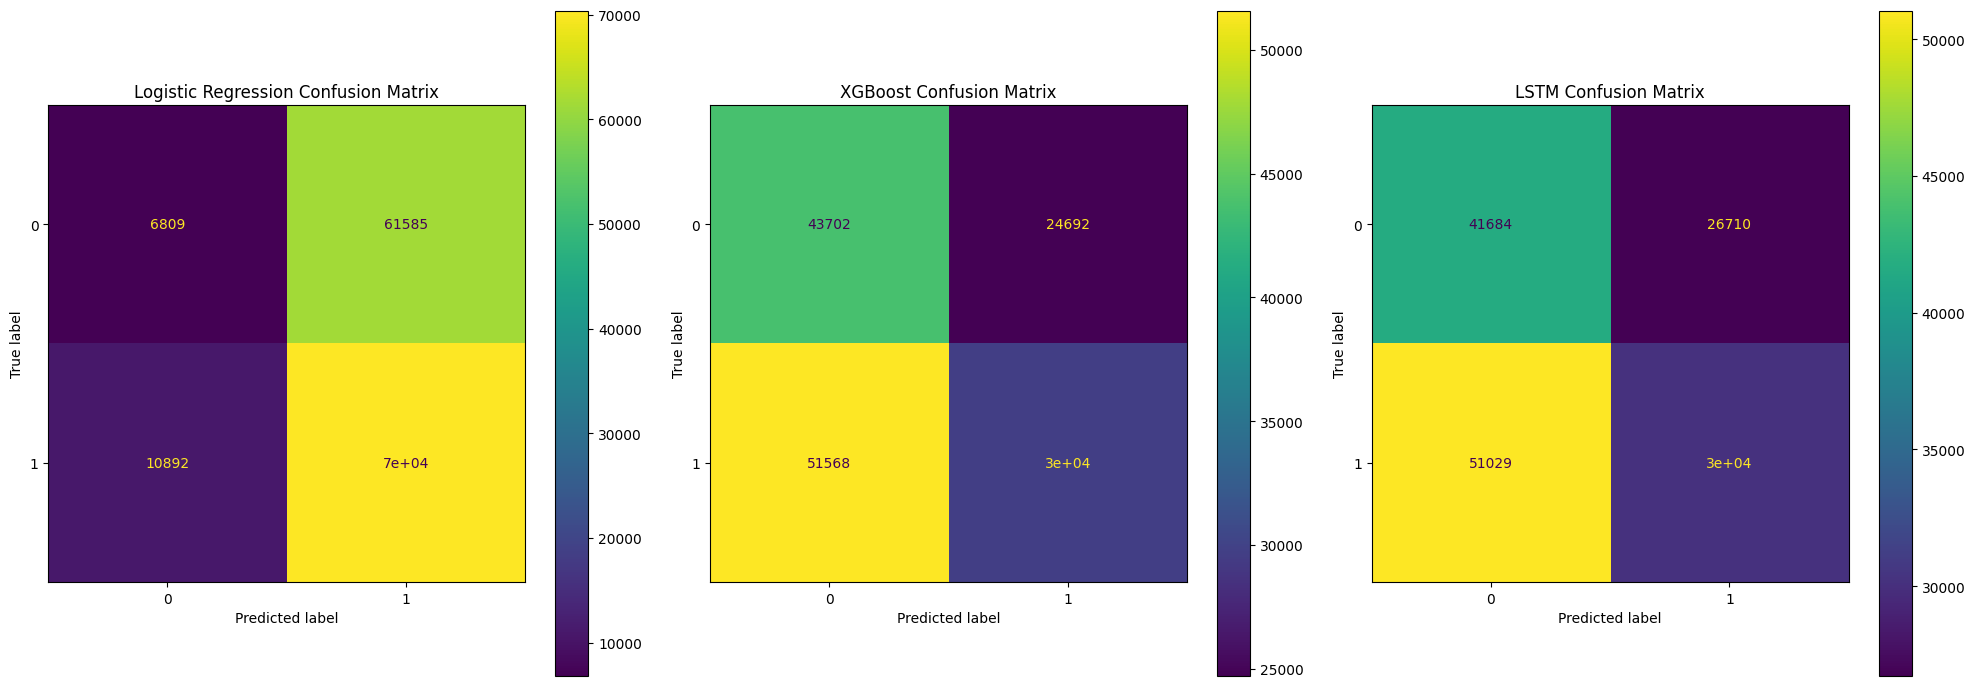

In [12]:
#################################
# Plot confusion matrices
#################################

# Set up subplot
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Plot
for i, m in model_map.items():
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, test_predictions[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot
    disp.plot(ax=axes[i], cmap='viridis')
    axes[i].set_title(f'{m} Confusion Matrix')
    
# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Accuracy, Precision, Recall, F1-Score
* **Accuracy**: Measure of how good the classifier is at predicting correctly. It's simply the number of predictions the classifier got right divided by the total number of predicitions it made. In the confusion, matrix, it's the sum of the leading diagonal divided by the sum of the whole matrix.

* **Precision**: For a given class, this measures how good the classifier is at not incorrectly labelling something as the class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of predictions that were labelled with that class.

* **Recall**: For a given class, this measures how good the classifier is at correctly labelling something as that class. For the given class, it's simply the number of predictions that were correctly labelled as that class divided by the total number of actual instances of that class.

* **F1-Score**: For a given class, this is a weighted harmonic mean of precision and recall where each are given equal importance. The best F1-score is 1 and the worst is 0.

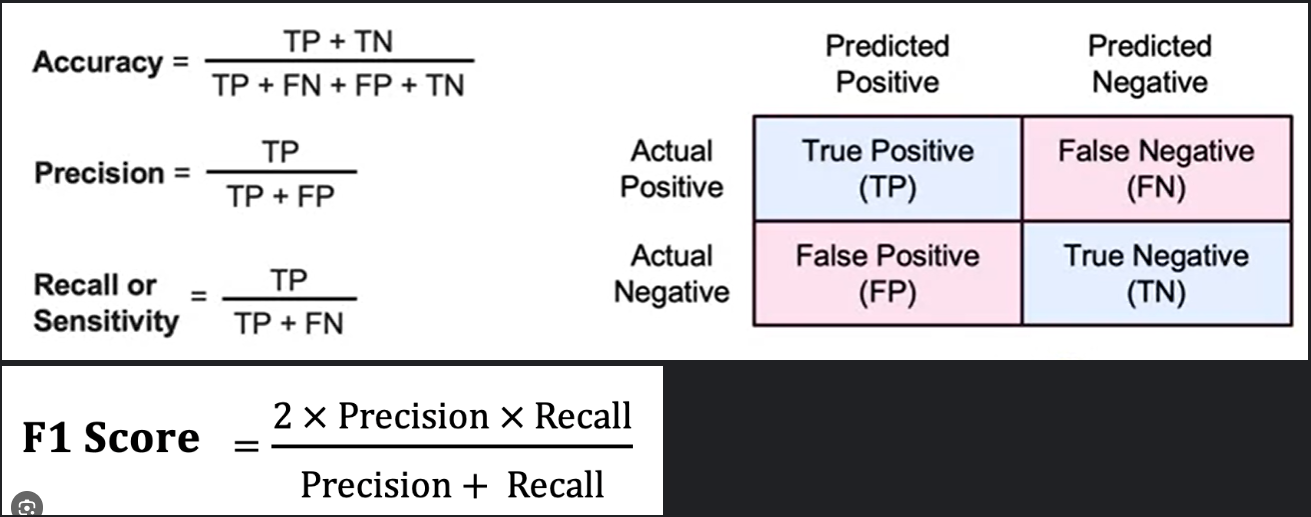

In [13]:
# Accuracy
for i in range(num_models):
    accuracy_test = accuracy_score(y_test, test_predictions[i])
    accuracy_train = accuracy_score(y_train, train_predictions[i])
    print(f"{model_map[i]} Test Accuracy {accuracy_test}")
    print(f"{model_map[i]} Training Accuracy {accuracy_train}")
    print("\n")

Logistic Regression Test Accuracy 0.5155636951828408
Logistic Regression Training Accuracy 0.5811609047818275


XGBoost Test Accuracy 0.49027812126113723
XGBoost Training Accuracy 0.6484007944331969


LSTM Test Accuracy 0.4803924845098288
LSTM Training Accuracy 0.5823230598822456




In [14]:
# Classification report showing precision, recall and F1 score for each class, as well accuracy and some averages
for i in range(num_models):
    cr = classification_report(y_test, test_predictions[i], digits=3)
    print(f"{model_map[i]}")
    print(cr)
    print("\n")

Logistic Regression
              precision    recall  f1-score   support

         0.0      0.385     0.100     0.158     68394
         1.0      0.533     0.866     0.660     81217

    accuracy                          0.516    149611
   macro avg      0.459     0.483     0.409    149611
weighted avg      0.465     0.516     0.431    149611



XGBoost
              precision    recall  f1-score   support

         0.0      0.459     0.639     0.534     68394
         1.0      0.546     0.365     0.437     81217

    accuracy                          0.490    149611
   macro avg      0.502     0.502     0.486    149611
weighted avg      0.506     0.490     0.482    149611



LSTM
              precision    recall  f1-score   support

         0.0      0.450     0.609     0.517     68394
         1.0      0.531     0.372     0.437     81217

    accuracy                          0.480    149611
   macro avg      0.490     0.491     0.477    149611
weighted avg      0.494     0.480    

### ROC Curve

Remember that the Logistic Regression algorithm uses probabilities to predict the class of a sample. For example, if the probability the sample belongs to class A is greater than 0.5 then it will be classified as Class A and if it's less than 0.5 it will be classified as Class B. This probability (0.5 in this case) is called the 'classification threshold'. A higher/lower classification threshold can change which data samples get classified as each class.

The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (aka. recall) against the False Positive Rate for varying levels of this classification threshold. As shown in the image below, TPR is simply the number of true positives relative to the total number of positives and FPR is the number of false positives relative to the total number of negatives. 

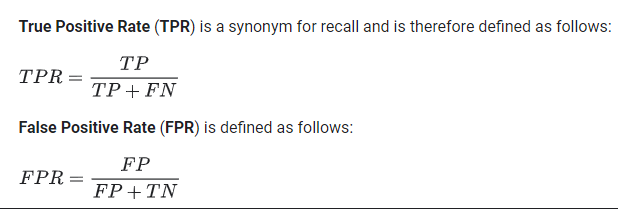

A typical ROC curve is shown below. The classification threshold is DECREASING from left to right. As we decrease the classification threshold, we classify more items as postiive, hence increasing both true positives and false positives.

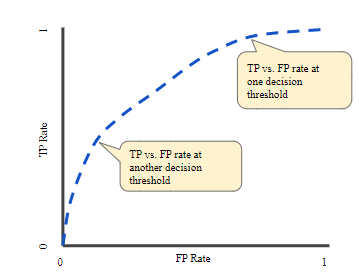

Note to plot this curve, we would need to train a model and then vary the classification threshold between 0 and 1 and calculate the TPR and FPR for each one.

### AUC

AUC stands for area under the ROC curve. It gives us an aggregate measure of performance across all classification thresholds. Since TPR and FPR are between 0 and 1, the value of AUC is also between 0 and 1.

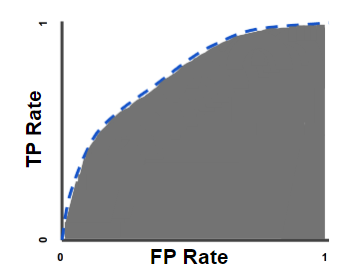

We can interpret AUC as the probability that a random positive example is assigned a higher probability by the regression model than a random negative sample. If the predictions are 100% correct, AUC will be 1 and if they're 100% wrong it will be 0. If the AUC is 0.5 then the model makes predicitions no better than random guessing.

Logistic Regression AUC is 0.45275813992272324
XGBoost AUC is 0.49236822097475513
LSTM AUC is 0.4939063038846287


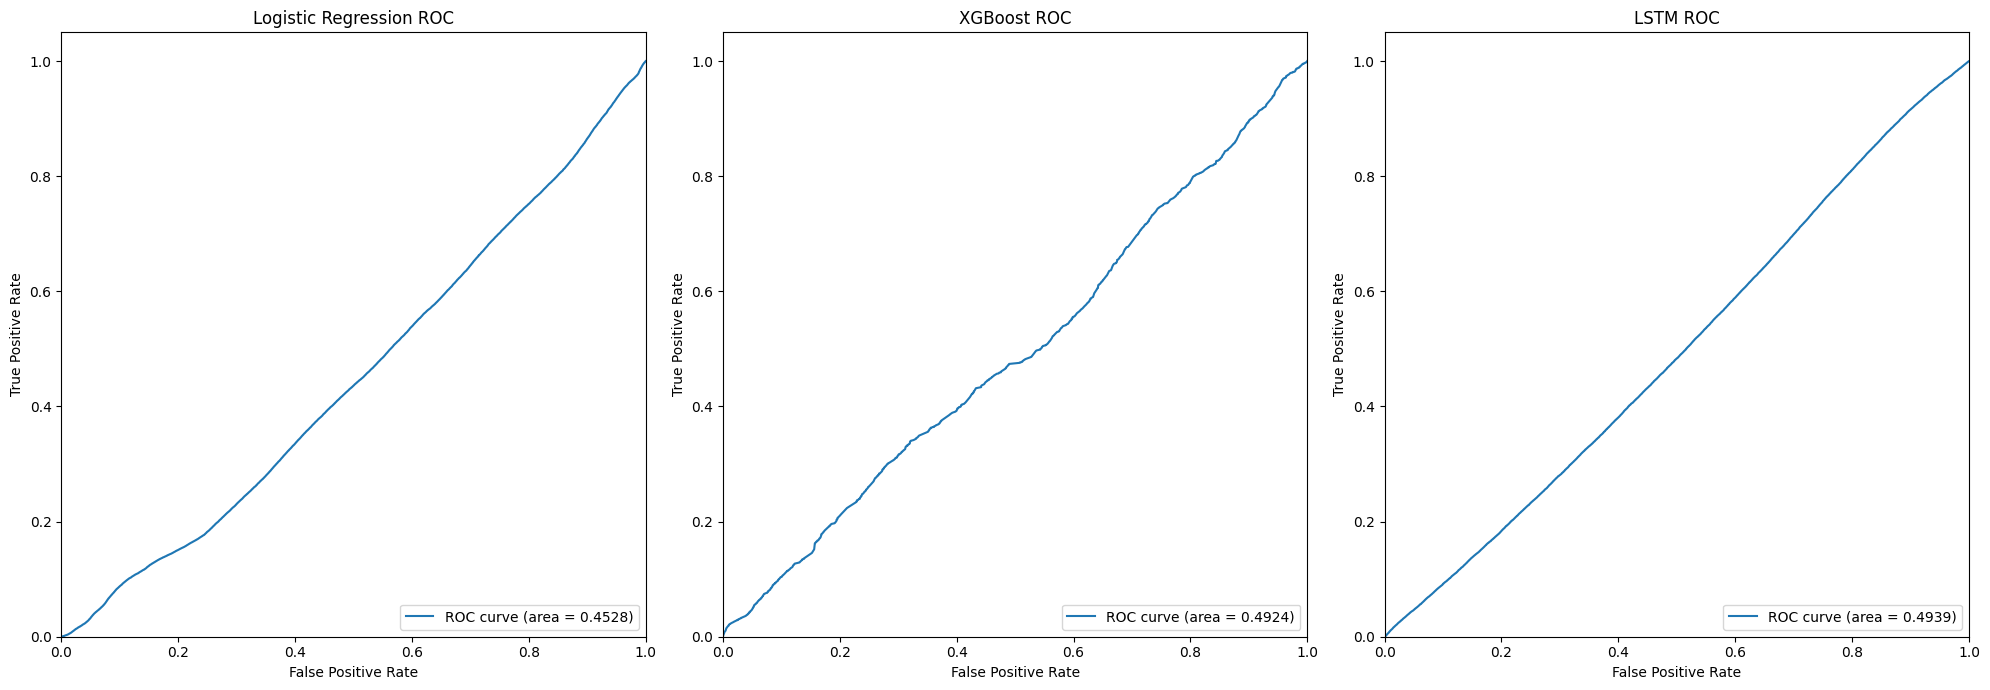

In [15]:
# Import
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Setup subplots
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(20, 7))

# Get probabilities of positive class
for i, m in model_map.items():
    # Compute roc curve
    fpr, tpr, thresholds = roc_curve(y_test, test_probabilities[i])

    # Compute AUC
    auc = roc_auc_score(y_test, test_probabilities[i])
    print(f"{m} AUC is {auc}")

    # Plot ROC curve
    ax = axes[i]
    ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{m} ROC')
    ax.legend(loc="lower right")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Strategies

### Data Prep

In [16]:
# Read data from eda notebook and convert symbol to stock id
df = pd.read_csv("/kaggle/input/ibm-classification-eda/data.csv", index_col=[0], parse_dates=['Date']).reset_index(drop=True)
df['Symbol'] = df['Symbol'].rank(method='dense', ascending=False).astype(int)

In [17]:
# Get predictions for all 3 models
preds = pd.DataFrame(
    data=X_test[['Date', 'Symbol']]
)
preds['Date'] = pd.to_datetime(preds['Date'])
for i, m in model_map.items():
    preds[f'{m} Prediction'] = test_predictions[i]

# Join predictions onto relevant columns from X_test
df = pd.merge(
    left=df[['Date', 'Symbol', 'Adj Close', 'S&P500']],
    right=preds[['Date', 'Symbol'] + [f'{m} Prediction' for m in model_map.values()]],
    on=['Date', 'Symbol']
).sort_values(by='Date').reset_index(drop=True)

In [18]:
def cumulative_values_sandp(df):
    """Function to calculate cumulative values of S&P 500"""
    
    # Create copy of dataframe
    cols = ['Date', 'S&P500']
    data = df.copy()[cols].drop_duplicates(subset='Date').reset_index(drop=True)
    
    # Calculate 1-week forward returns of S&P
    data['S&P500 T+5'] = data['S&P500'].shift(-5)
    data['S&P500 1-Week Forward Return'] = (data['S&P500 T+5'] - data['S&P500']) / data['S&P500']
    
    # Calculate accumlated values of S&P500
    data['S&P500 Value'] = (1 + data['S&P500 1-Week Forward Return']).cumprod()
    
    # Drop unecessary columns
    data.drop(['S&P500 T+5', 'S&P500', 'S&P500 1-Week Forward Return'], axis=1, inplace=True)
    
    # Drop Nans (at end of data)
    data.dropna(inplace=True)
    
    return data

In [19]:
def cumulative_values(df, model_map):
    """Function to calculate cumulative values for plotting assuming an equally weighted portfolio rebalanced weekly. Strategy is long-short."""
    
    # Model names
    model_names = model_map.values()
    
    # Create copy of dataframe
    data = df.copy()
    
    # Calculate 1-week forward returns of each stock
    data['Adj Close T+5'] = data.groupby('Symbol')['Adj Close'].shift(-5)
    data['Adj Close 1-Week Forward Return'] = (data['Adj Close T+5'] - data['Adj Close']) / data['Adj Close']
    data.drop(['Adj Close T+5', 'Adj Close'], axis=1, inplace=True)
    
    # Calculate strategy return for each model
    for m in model_names:
        # Set short positions with -1 (longs are already 1)
        data[f'{m} Position'] = data[f'{m} Prediction'].replace({0: -1})

        # Calculate return of position
        data[f'{m} Position Return'] = data['Adj Close 1-Week Forward Return'] * data[f'{m} Position']

        # Calculate strategy return (equal weight portfolio)
        data[f"{m} Strategy Return"] = data.groupby('Date')[f'{m} Position Return'].transform(func='mean')

    # Drop duplicate dates, unecessary columns and drop nans at end of time period (they don't have a forward return)
    data.drop_duplicates(subset='Date', inplace=True)
    to_drop = [f"{m} {c}" for m in model_map.values() for c in ['Position', 'Position Return', 'Prediction']] + ['Symbol', 'Adj Close 1-Week Forward Return']
    data.drop(to_drop, axis=1, inplace=True)
    data.dropna(inplace=True)

    # Calculate accumulated values from strategy return, then drop strategy return
    col_names = [f"{m} Strategy Value" for m in model_names]
    strategy_return_cols = [f'{m} Strategy Return' for m in model_names]
    data[col_names] = (1 + data[strategy_return_cols]).cumprod()
    data.drop(strategy_return_cols, axis=1, inplace=True)
        
    return data

In [20]:
# Get accumulated values for strategies
strategy_data = cumulative_values(df=df.drop('S&P500', axis=1), model_map=model_map)

# Get accumulated values for S&P
sandp_data = cumulative_values_sandp(df=df)

# Join strategy data with S&P Data
to_plot = pd.merge(
    left=strategy_data,
    right=sandp_data,
    on='Date'
).reset_index(drop=True)
to_plot.set_index('Date', inplace=True)

### Plots

<Axes: title={'center': 'Performance of equally-weighted long-short portfolios'}, xlabel='Date'>

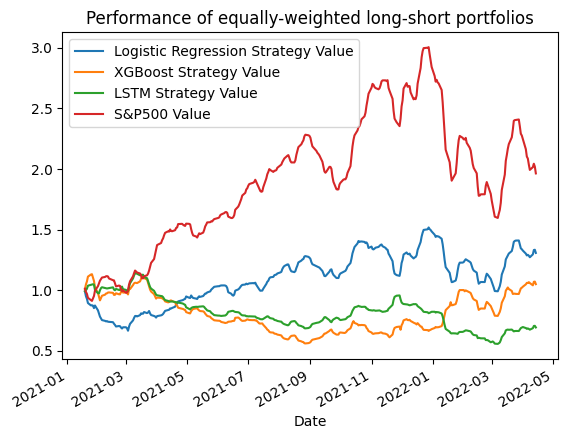

In [21]:
# Plot performance of strategies
to_plot.plot(title='Performance of equally-weighted long-short portfolios')